In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [3]:
!pip install --quiet tensorflow-addons
!pip install --quiet comet_ml
!pip install --quiet tf-keras-vis tensorflow
!pip install  --quiet natsort
!pip install  --quiet -U segmentation-models
!pip install --quiet ipython-autotime
!pip install --quiet ipy-autotimebar

%load_ext autotime
%load_ext autotimebar

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 388 kB 5.1 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 158 kB 53.2 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 495 kB 70.7 MB/s 
     |████████████████████████████████| 140 kB 73.8 MB/s 
     |████████████████████████████████| 127 kB 64.3 MB/s 
     |████████████████████████████████| 157 kB 67.9 MB/s 
     |████████████████████████████████| 157 kB 79.3 MB/s 
     |████████████████████████████████| 157 kB 57.0 MB/s 
     |████████████████████████████████| 157 kB 70.3 MB/s 
     |████████████████████████████████| 157 kB 71.7 MB/s 
     |████████████████████████████████| 157 kB 66.0 MB/s 
     |████████████████████████████████| 157 kB 57.2 MB/s 
     |████████████████████████████████| 156 kB 73.3 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████

Label(value='0s')

time: 61.2 ms (started: 2022-09-11 11:21:18 +00:00)


In [4]:
#@title Check available GPU in session
#  ------------------------------------
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# ----------------------------------------------
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Label(value='0s')

Sun Sep 11 11:21:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%cd '/content/drive/MyDrive/Colab Notebooks/SpecSeg/'

import tensorflow as tf
import cv2
import os
import random

import numpy as np
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from matplotlib import cm, pyplot as plt
from packaging import version
from tensorflow.keras import mixed_precision
from tensorflow.python.ops.init_ops_v2 import Initializer
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.initializers import RandomUniform, RandomNormal

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection
from skimage.transform import resize
from skimage.color import rgb2gray
from PIL import Image
from sklearn.model_selection import train_test_split
from natsort import natsorted
import segmentation_models as sm

Label(value='0s')

/content/drive/MyDrive/Colab Notebooks/SpecSeg
Segmentation Models: using `keras` framework.
time: 10.1 s (started: 2022-09-11 11:21:27 +00:00)


In [6]:
def specseg(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c1)
    c1 = BatchNormalization(axis=-1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c2)
    c2 = BatchNormalization(axis=-1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c3)
    c3 = BatchNormalization(axis=-1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c4)
    c4 = BatchNormalization(axis=-1)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c5)
    c5 = BatchNormalization(axis=-1)(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='RandomNormal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5]))
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    opt = tf.keras.optimizers.Adam(learning_rate=0.00002)
    
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    model.compile(optimizer=opt, loss=total_loss, metrics=metrics)
    model.summary()

    return model

Label(value='0s')

time: 25.1 ms (started: 2022-09-11 11:21:39 +00:00)


In [7]:

# --------------------------------------------------------------
#                       LOAD DATASET                           |
# --------------------------------------------------------------
image_directory =  '/content/drive/MyDrive/Colab Notebooks/Datasets/WHU-specular-dataset/Train/HighlightImages/'
mask_directory =  '/content/drive/MyDrive/Colab Notebooks/Datasets/WHU-specular-dataset/Train/HighlightMasks/'

SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

print("loading images")
images = natsorted(os.listdir(image_directory))
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize( (SIZE, SIZE) )
        # q = np.array(image)
        image_dataset.append( np.array(image) )

print("loading masks")
masks = natsorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize( (SIZE, SIZE) )
        mask_dataset.append( np.array(image) )

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


Label(value='0s')

loading images
loading masks
time: 3min 16s (started: 2022-09-11 11:21:44 +00:00)


Label(value='0s')

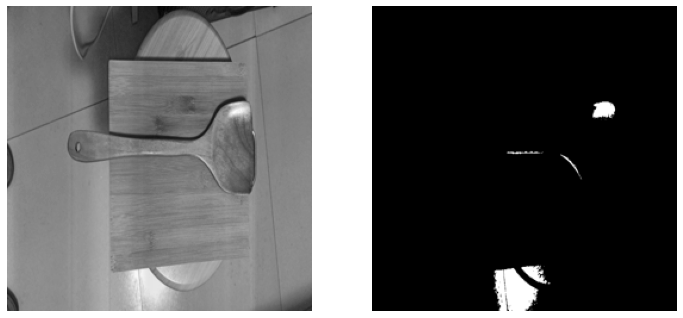

time: 201 ms (started: 2022-09-11 11:25:19 +00:00)


In [10]:
#To check if data loaded correctly
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
#############################################################
#  TRAIN 
#############################################################


%cd '/content/drive/MyDrive/Colab Notebooks/SpecSeg/'

model = specseg(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_split=0.2,
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('SpecSeg_weights.hdf5')

Label(value='0s')

/content/drive/MyDrive/Colab Notebooks/SpecSeg
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )              

Label(value='0s')

10/10 [==============================] - 2s 43ms/step - loss: 0.8021 - iou_score: 0.2671 - f1-score: 0.4196
SparseCategoricalCrossentropy =  [0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486, 0.2671293020248413, 0.4195515215396881, 0.8020567297935486

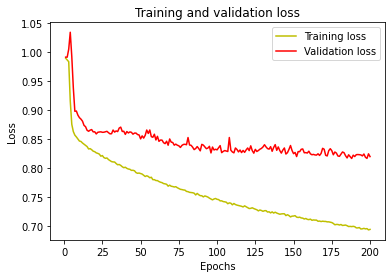

IoU socre is:  0.27947576887750225


<Figure size 432x288 with 0 Axes>

time: 3.03 s (started: 2022-08-11 10:10:03 +00:00)


In [ ]:
############################################################
#Evaluate the model
# sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
FScore = model.evaluate(X_test, y_test)
print("SparseCategoricalCrossentropy = ", (FScore * 100), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plt.imsave("TrgLoss", epochs)
plt.savefig('TrgLoss1600.png')

##################################
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


Label(value='0s')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

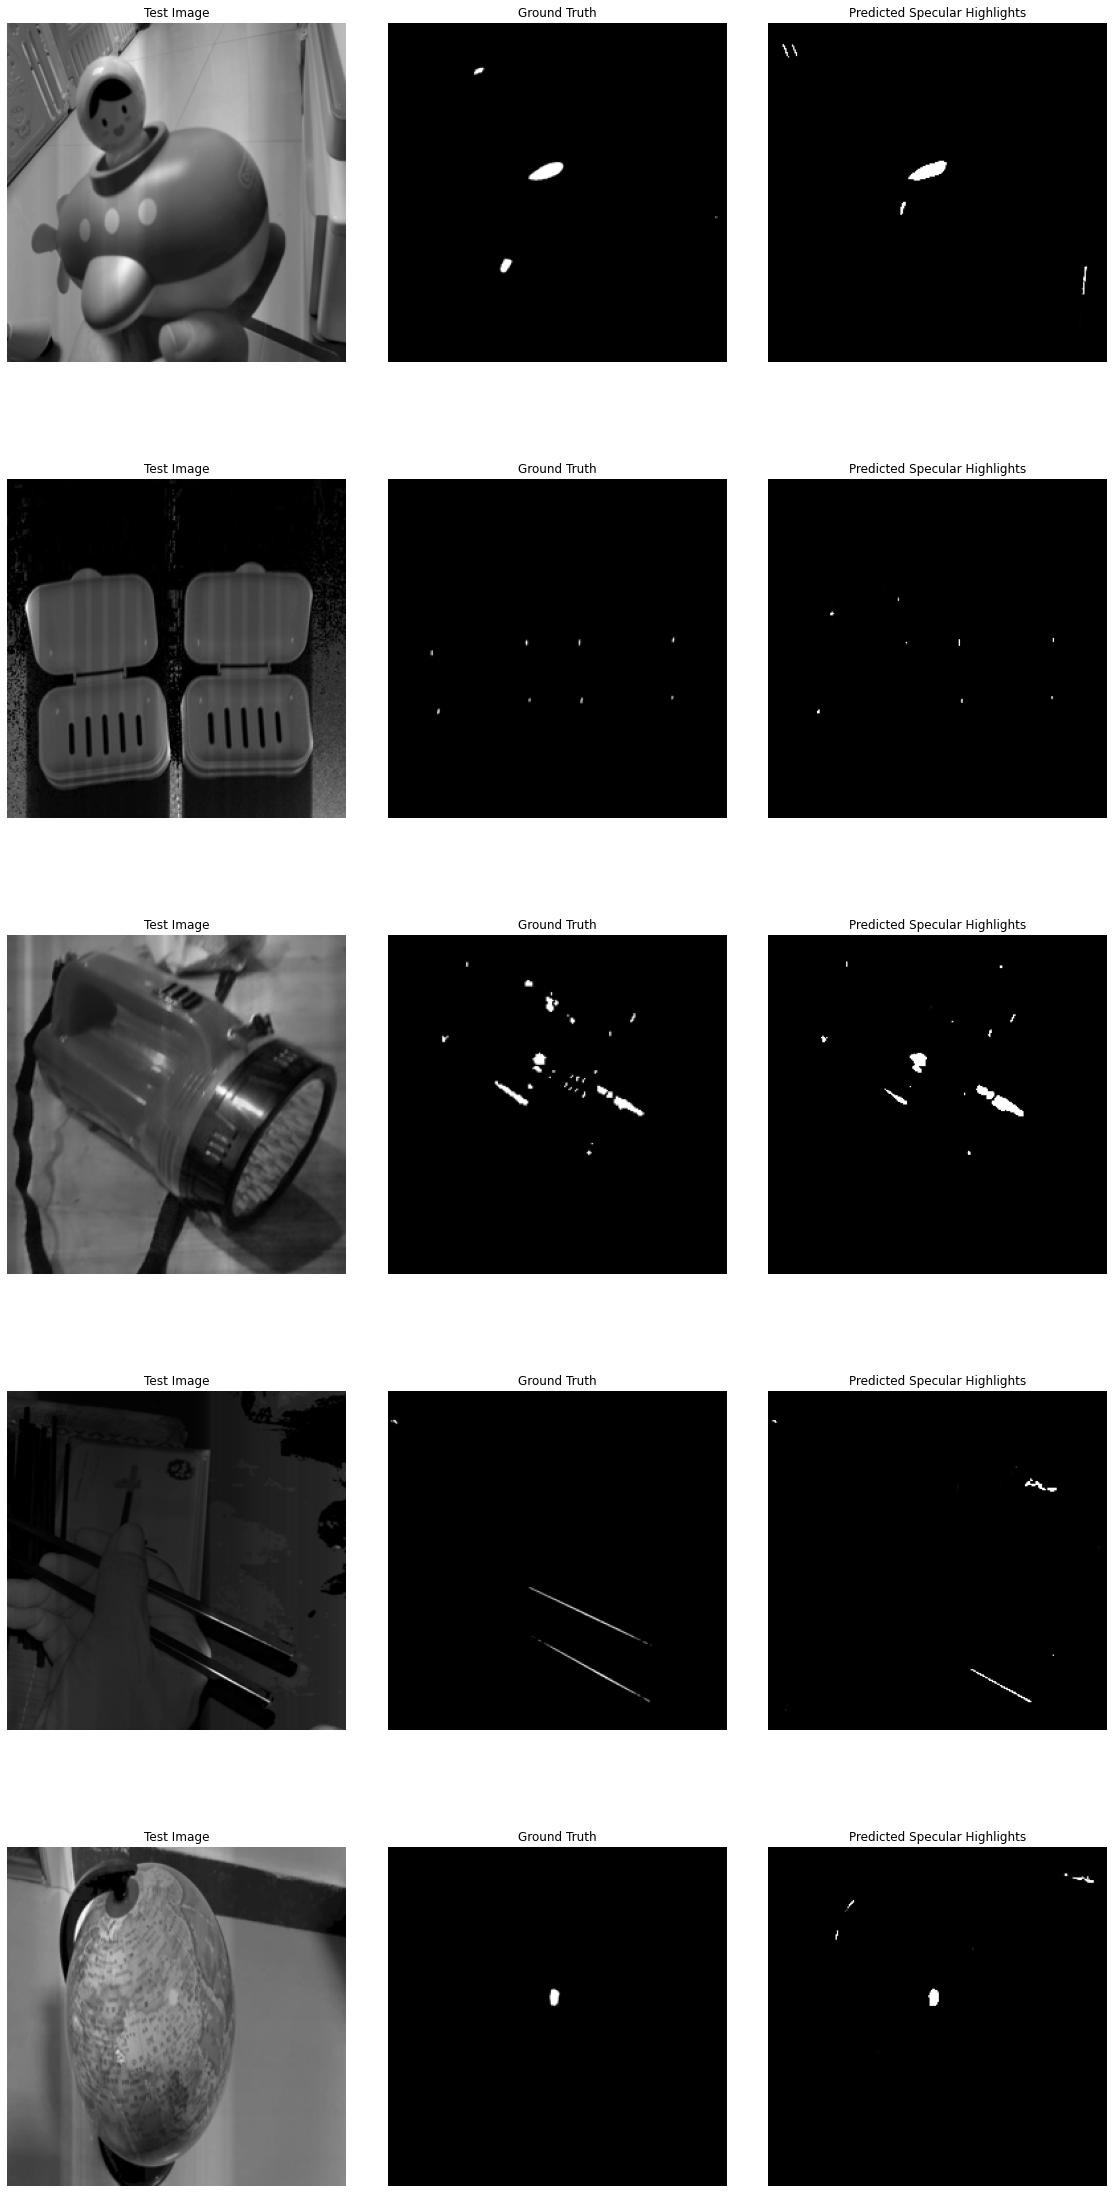

time: 5.24 s (started: 2022-09-11 11:26:26 +00:00)


In [12]:
#######################################################################
#Predict on a few images
model = specseg(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model.load_weights('SpecSeg_weights.hdf5') #Trained for 50 epochs and then additional 100

# Enter number of images to test on
num_images = 5
index = 0
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,32))
fig.tight_layout()
for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0] )

    plt.subplot(num_images,3,index+1)
    plt.title('Test Image')
    plt.axis('off')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(num_images,3,index+2)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(num_images,3,index+3)
    plt.title('Predicted Specular Highlights')
    plt.axis('off')
    plt.imshow(prediction, cmap='gray')
    index = 3 * (i+1)
fig.savefig('predictions.png')   # save the figure to file
print("Done!")

In [ ]:
# ------------------------------------------------
#  Test on Random Images
# ------------------------------------------------

image_directory =  '/content/drive/MyDrive/Colab Notebooks/Datasets/WHU-specular-dataset/Test/HighlightImages/'
mask_directory =  '/content/drive/MyDrive/Colab Notebooks/Datasets/WHU-specular-dataset/Test/HighlightMasks/'

SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

print("loading real-world test images...")
images = natsorted(os.listdir(image_directory))
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory+image_name , 0)
        image = Image.fromarray(image)
        image = image.resize( (SIZE, SIZE) )
        image_dataset.append( np.array(image) )

masks = natsorted(os.listdir(mask_directory))
for i, mask_name in enumerate(masks):
    if (mask_name.split('.')[1] == 'png'):
        mask = cv2.imread(mask_directory+mask_name, 0)
        mask = Image.fromarray(mask)
        mask = mask.resize( (SIZE, SIZE) )
        mask_dataset.append( np.array(mask) )

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

Label(value='0s')

loading real-world test images...
time: 27.2 s (started: 2022-08-12 14:40:35 +00:00)


Label(value='0s')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 256, 256, 16  160         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_81 (Dropout)           (None, 256, 256, 16  0           ['conv2d_171[0][0]']             
                                )                                                           

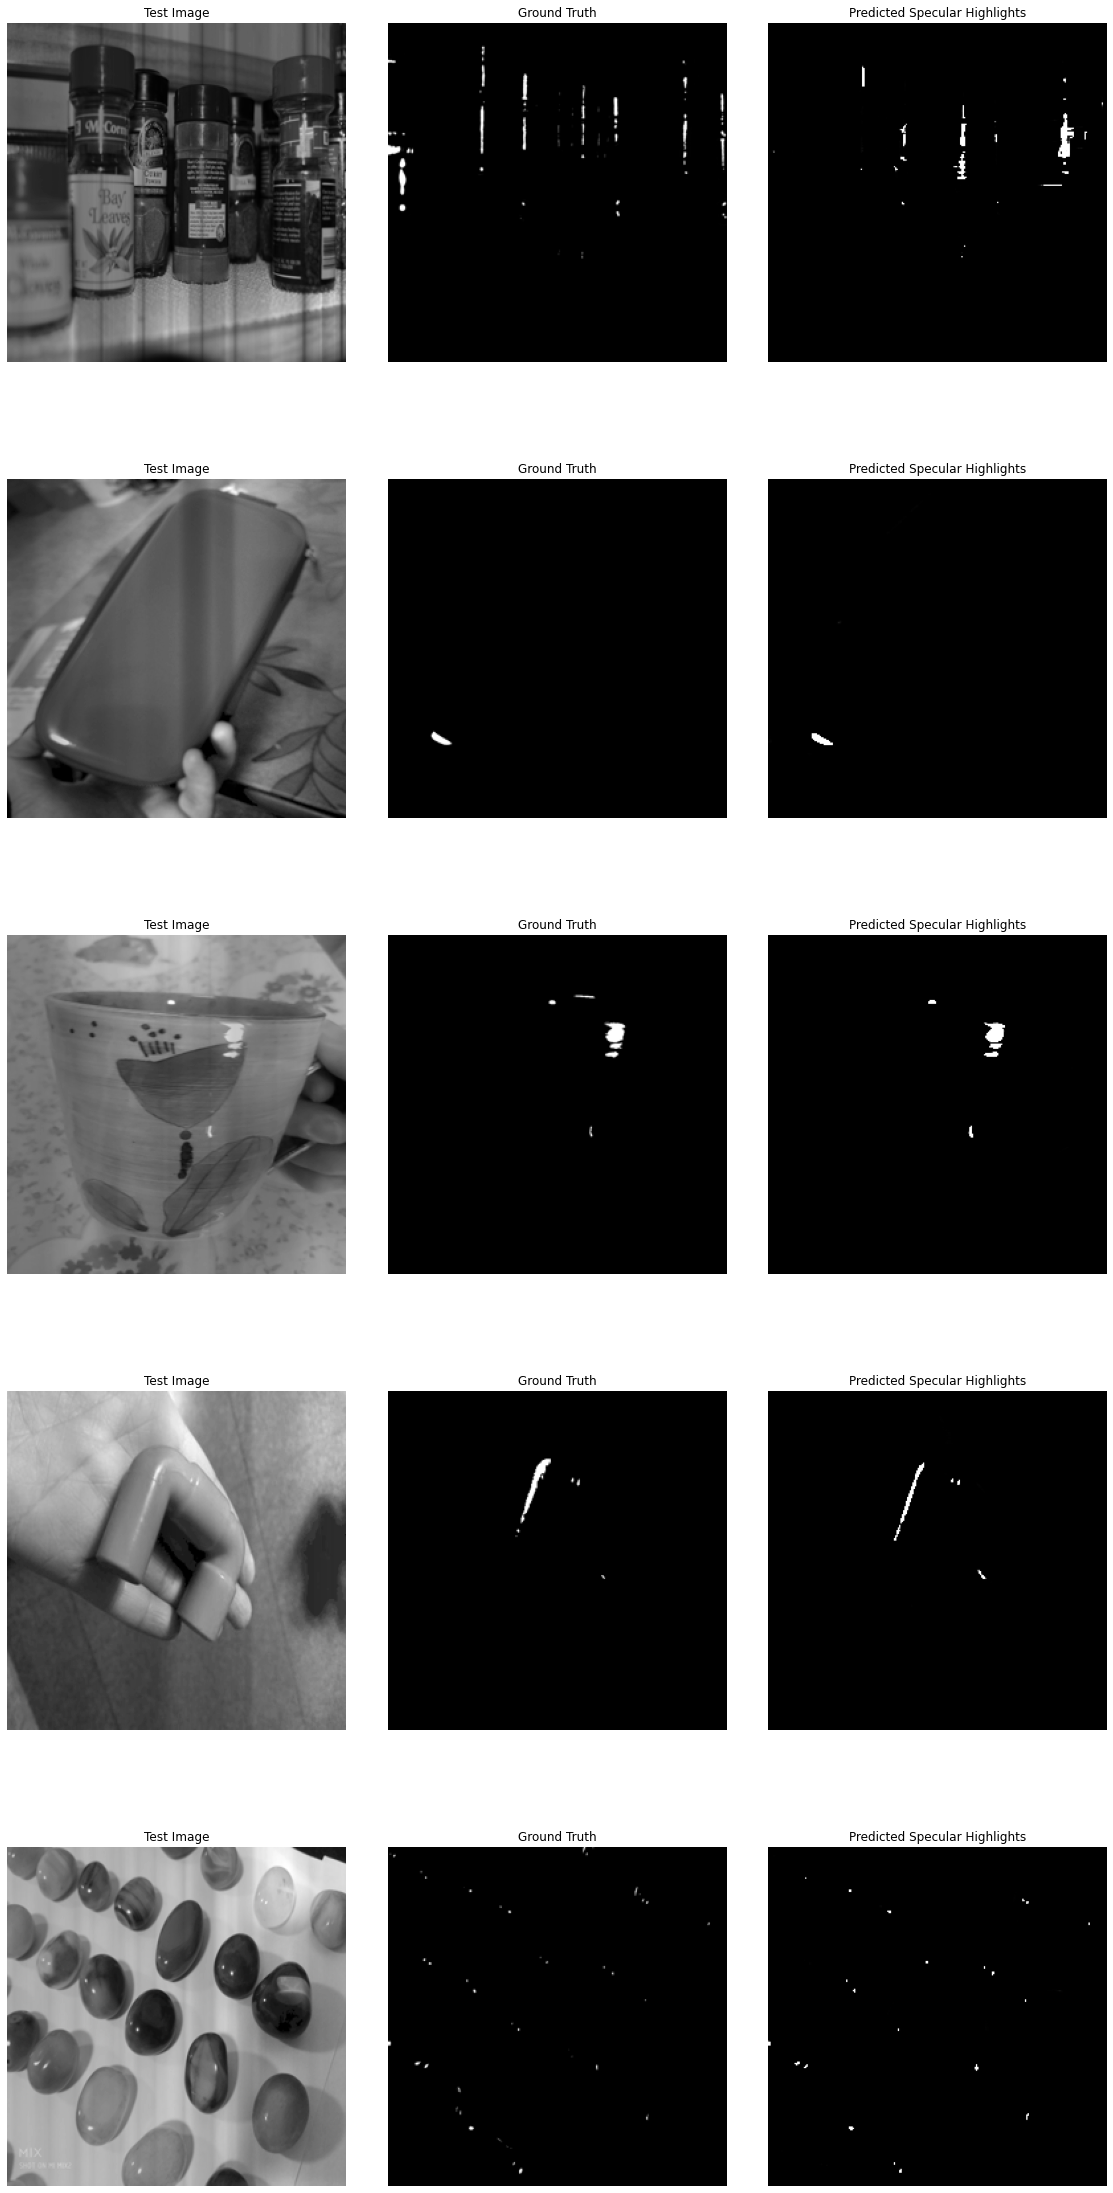

time: 7.73 s (started: 2022-09-11 11:32:14 +00:00)


In [20]:
model = specseg(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model.load_weights('SpecSeg_weights.hdf5') #Trained for 50 epochs and then additional 100

# Enter number of images to test on
num_images = 5
index = 0
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,32))
fig.tight_layout()
for i in range(num_images):
    test_img_number = i
    test_img = image_dataset[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0] )
    # --------------TEST IMAGE-----------------
    plt.subplot(num_images,3,index+1)
    plt.title('Test Image')
    plt.axis('off')
    plt.imshow(test_img[:,:,0], cmap='gray')
    name="./results_randomTestImages/img_" + str(i) + '.png'
    plt.imsave(name, test_img[:,:,0], cmap='gray')
    
    # --------------GT -----------------
    ground_truth=mask_dataset[test_img_number]
    plt.subplot(num_images,3,index+2)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    name="./results/gt" + str(i) + '.png'

    # --------------PREDICTION-----------------
    plt.subplot(num_images,3,index+3)
    plt.title('Predicted Specular Highlights')
    plt.axis('off')
    plt.imshow(prediction, cmap='gray')
    name="./results_randomTestImages/prediction_" + str(i) + '.png'
    plt.imsave(name, prediction, cmap='gray')

    index = 3 * (i+1)

# plt.imsave('/results/output2.jpg', fig)
fig.savefig('randomTestImages-random.png')   # save the figure to file
print ("Done and Done!")